# Qsub quick overview

## Introduction

This notebook will show you how to use Qsub to construct structured quantum programs that represents FTQC algorithms. Let's look at how to use Qsub, step by step, in the following order!

- [`Op` and `Sub`](#Op-and-Sub)
    - First, we will explain `Op` and `Sub`, which represent arbitrary quantum operations in Qsub.
- [Standard predefined `Op`s: `qsub.lib.std`](#Standard-predefined-Ops:-qsub.lib.std)
    - Next, we will introduce predefined `Op`s, which is provided in the standard library.
- [Resolving `Op` to `Sub`](#Resolving-Op-to-Sub)
- [Compile and analyze a `Sub`](#Compile-and-analyze-a-Sub)
    - The `Sub` thus created must be resolved and compiled in order to perform resource estimation and generate quantum circuits for QURI Parts. The following sections describe these resolve and compile processes. 
- [Custom `Op` and `Sub`](#Custom-Op-and-Sub)
    - Users can define their own `Op` and `Sub`, which can be used in the same way as predefined `Op` and `Sub`. The last section describes how to create such custom `Op` and `Sub`.

## `Op` and `Sub`

In Sub a circuit is represented as a `Sub` (subroutine) object. A `Sub` is defined as a sequence of operations on qubits and classical registers.

The most basic thing you can do is to define a `Sub` using predefined `Op`s.

In [ ]:
from quri_parts.qsub.sub import SubBuilder

# Predefined Ops
from quri_parts.qsub.lib.std import H, CNOT, RZ

# Build a circuit for 2 qubits
b = SubBuilder(2)
q0, q1 = b.qubits
b.add_op(H, (q1,))
b.add_op(CNOT, (q0, q1))
b.add_op(RZ(-0.5), (q1,))
b.add_op(CNOT, (q0, q1))
b.add_op(RZ(0.5), (q1,))
b.add_op(H, (q1,))
sub = b.build()

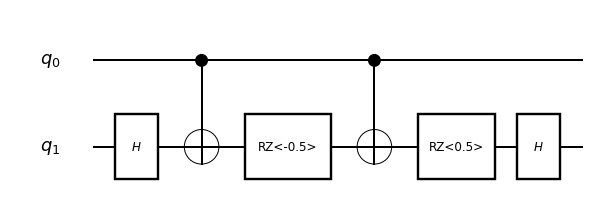

In [ ]:
from quri_parts.qsub.visualize import draw_sub

draw_sub(sub)

Some `Op`s are parametric: in the above example, `RZ` is a parametric `Op`. It is just a function returning a (non-parametric) `Op`: `RZ(0.5)` is an `Op` with the fixed parameter 0.5.

## Standard predefined `Op`s: `qsub.lib.std`

`qsub.lib.std` package contains the following standard pre-defined `Op`s.

In [ ]:
from math import pi
from quri_parts.qsub.lib import std

print("Single qubit non-parametric gates:")
for op in [
    std.X,
    std.Y,
    std.Z,
    std.H,
    std.SqrtX,
    std.SqrtXdag,
    std.SqrtY,
    std.SqrtYdag,
    std.S,
    std.Sdag,
    std.T,
    std.Tdag,
]:
    print(" ", op)

print("Single qubit parametric rotation gates:")
for op in [
    std.RX,
    std.RY,
    std.RZ,
    std.Phase,
]:
    print(" ", op(pi/8))

print("Two qubit non-parametric gates:")
for op in [
    std.CNOT,
    std.CZ,
    std.SWAP,
]:
    print(" ", op)

print("Three qubit non-parametric gates:")
print(" ", std.Toffoli)

print("Measurement:")
print(" ", std.M)

print("Classical conditional branching:")
for op in [
    std.Cbz,
    std.Label,
]:
    print(" ", op)


_ = [
    
    "conditional",
    
    "Inverse",
    "Controlled",
    "MultiControlled",
    "scoped_and",
    "scoped_and_clifford_t",
]


Single qubit non-parametric gates:
  lib.std.X(qubits=1, registers=0)
  lib.std.Y(qubits=1, registers=0)
  lib.std.Z(qubits=1, registers=0)
  lib.std.H(qubits=1, registers=0)
  lib.std.SqrtX(qubits=1, registers=0)
  lib.std.SqrtXdag(qubits=1, registers=0)
  lib.std.SqrtY(qubits=1, registers=0)
  lib.std.SqrtYdag(qubits=1, registers=0)
  lib.std.S(qubits=1, registers=0)
  lib.std.Sdag(qubits=1, registers=0)
  lib.std.T(qubits=1, registers=0)
  lib.std.Tdag(qubits=1, registers=0)
Single qubit parametric rotation gates:
  lib.std.RX<0.39269908169872414>(qubits=1, registers=0)
  lib.std.RY<0.39269908169872414>(qubits=1, registers=0)
  lib.std.RZ<0.39269908169872414>(qubits=1, registers=0)
  lib.std.Phase<0.39269908169872414>(qubits=1, registers=0)
Two qubit non-parametric gates:
  lib.std.CNOT(qubits=2, registers=0)
  lib.std.CZ(qubits=2, registers=0)
  lib.std.SWAP(qubits=2, registers=0)
Three qubit non-parametric gates:
  lib.std.Toffoli(qubits=3, registers=0)
Measurement:
  lib.std.M(qu

There are some parametric `Op`s that take another `Op` as their argument.

### Inverse

`Inverse` returns inverse of a given unitary operation.

In [ ]:
from quri_parts.qsub.lib import std

invS = std.Inverse(std.S)
print(invS)

lib.std.Inverse<lib.std.S>(qubits=1, registers=0)


### Controlled

`Controlled` represents a controlled operation of a given unitary operation. If the given unitary is $n$-qubit operation, then the returned controlled operation is $n+1$-qubit operation; The first qubit is the control qubit.

In [ ]:
from quri_parts.qsub.lib import std

ctrlS = std.Controlled(std.S)
print(ctrlS)

ctrlToffoli = std.Controlled(std.Toffoli)
print(ctrlToffoli)

lib.std.Controlled<lib.std.S>(qubits=2, registers=0)
lib.std.Controlled<lib.std.Toffoli>(qubits=4, registers=0)


### MultiControlled

`MultiControlled` represents a multi-bit controlled operation of a given unitary operation. It takes three arguments: the target unitary `Op`, number of control bits (int) and control value (int). The control value is interpreted by binary representation: e.g. if `control_value=0b10100`, it is interpreted as `bit0=0`, `bit1=0`, `bit2=1`, `bit3=0` and `bit4=1`.

In [ ]:
from quri_parts.qsub.lib import std

mctrlS = std.MultiControlled(std.S, 3, 0b010)
print(mctrlS)

lib.std.MultiControlled<lib.std.S, 3, 2>(qubits=4, registers=0)


## Resolving `Op` to `Sub`

An `Op` itself is just an abstract symbol. Eventually it needs to be resolved as either a primitive (native gate) or a `Sub`. How each `Op` should be resolved can be registered to a `SubRepository`, though users usually don't need to be aware of it since we provide a *default* `SubRepository`. In order to get a `Sub` corresponding to an `Op`, you can use `resolve_sub()` function. If no correspondence is registered for the given `Op`, it returns `None`:

In [ ]:
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.lib import std

subS = resolve_sub(std.S)
print(subS)

None


Most operations in `qsub.lib.std` are usually treated as primitives, so no correspondence for them is registered by default.

### Resolving Inverse

Correspondences for `Inverse` of standard operations are registered by default.

In [ ]:
from math import pi
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.lib import std

print("Single qubit non-parametric gates:")
for op in [
    std.X,
    std.Y,
    std.Z,
    std.H,
    std.SqrtX,
    std.SqrtXdag,
    std.SqrtY,
    std.SqrtYdag,
    std.S,
    std.Sdag,
    std.T,
    std.Tdag,
]:
    inv = std.Inverse(op)
    inv_sub = resolve_sub(inv)
    print(f" Inverse({op.base_id[1]}): {inv_sub}")

print("Single qubit parametric rotation gates:")
for op in [
    std.RX,
    std.RY,
    std.RZ,
    std.Phase,
]:
    inv = std.Inverse(op(pi/8))
    inv_sub = resolve_sub(inv)
    print(f" Inverse({op.base_id[1]}(pi/8)): {inv_sub}")

print("Two qubit non-parametric gates:")
for op in [
    std.CNOT,
    std.CZ,
    std.SWAP,
]:
    inv = std.Inverse(op)
    inv_sub = resolve_sub(inv)
    print(f" Inverse({op.base_id[1]}): {inv_sub}")

print("Three qubit non-parametric gates:")
inv = std.Inverse(std.Toffoli)
inv_sub = resolve_sub(inv)
print(f" Inverse({std.Toffoli.base_id[1]}): {inv_sub}")

Single qubit non-parametric gates:
 Inverse(X): Sub[lib.std.X(q0)]
 Inverse(Y): Sub[lib.std.Y(q0)]
 Inverse(Z): Sub[lib.std.Z(q0)]
 Inverse(H): Sub[lib.std.H(q0)]
 Inverse(SqrtX): Sub[lib.std.SqrtXdag(q0)]
 Inverse(SqrtXdag): Sub[lib.std.SqrtX(q0)]
 Inverse(SqrtY): Sub[lib.std.SqrtYdag(q0)]
 Inverse(SqrtYdag): Sub[lib.std.SqrtY(q0)]
 Inverse(S): Sub[lib.std.Sdag(q0)]
 Inverse(Sdag): Sub[lib.std.S(q0)]
 Inverse(T): Sub[lib.std.Tdag(q0)]
 Inverse(Tdag): Sub[lib.std.T(q0)]
Single qubit parametric rotation gates:
 Inverse(RX(pi/8)): Sub[lib.std.RX<-0.39269908169872414>(q0)]
 Inverse(RY(pi/8)): Sub[lib.std.RY<-0.39269908169872414>(q0)]
 Inverse(RZ(pi/8)): Sub[lib.std.RZ<-0.39269908169872414>(q0)]
 Inverse(Phase(pi/8)): Sub[lib.std.Phase<-0.39269908169872414>(q0)]
Two qubit non-parametric gates:
 Inverse(CNOT): Sub[lib.std.CNOT(q0, q1)]
 Inverse(CZ): Sub[lib.std.CZ(q0, q1)]
 Inverse(SWAP): Sub[lib.std.SWAP(q0, q1)]
Three qubit non-parametric gates:
 Inverse(Toffoli): Sub[lib.std.Toffoli(q0, 

### Resolving Controlled

Correspondences for `Controlled` of standard operations are registered by default.

Single qubit non-parametric gates:
 Controlled(X):


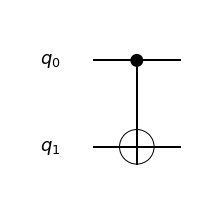

 Controlled(Y):


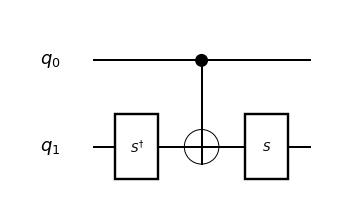

 Controlled(Z):


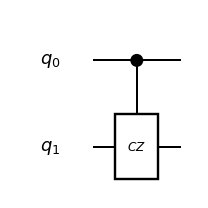

 Controlled(H):


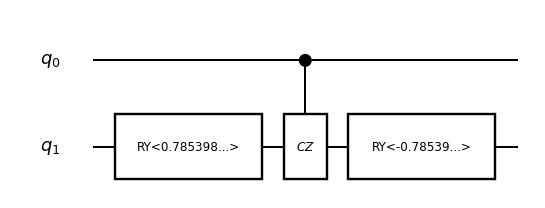

 Controlled(SqrtX):


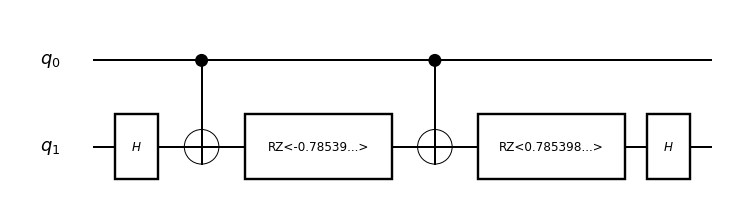

 Controlled(SqrtXdag):


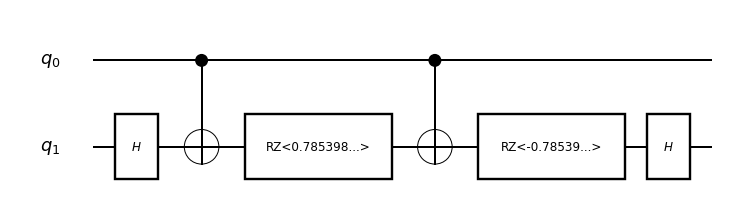

 Controlled(SqrtY):


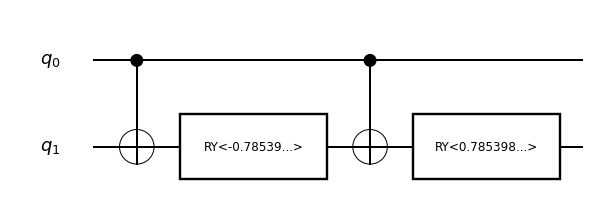

 Controlled(SqrtYdag):


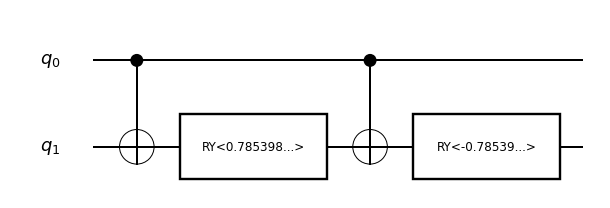

 Controlled(S):


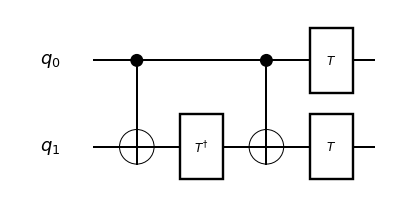

 Controlled(Sdag):


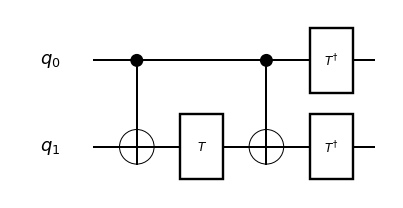

 Controlled(T):


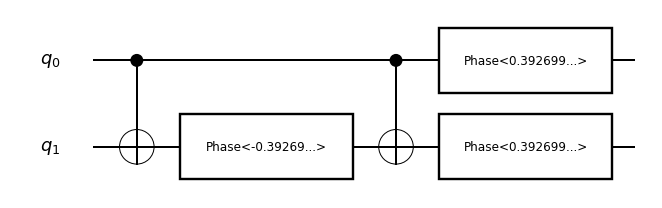

 Controlled(Tdag):


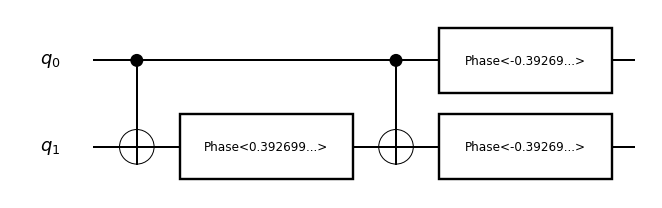

Single qubit parametric rotation gates:
 Controlled(RX(pi/8)):


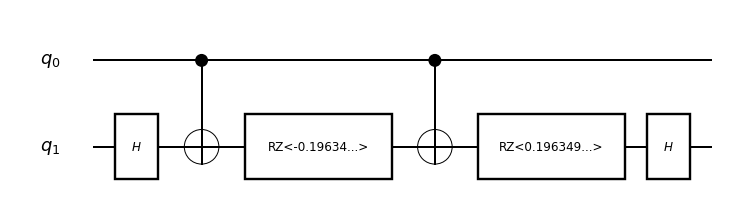

 Controlled(RY(pi/8)):


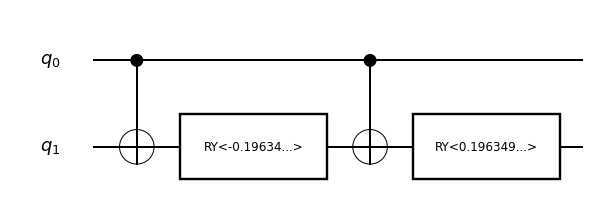

 Controlled(RZ(pi/8)):


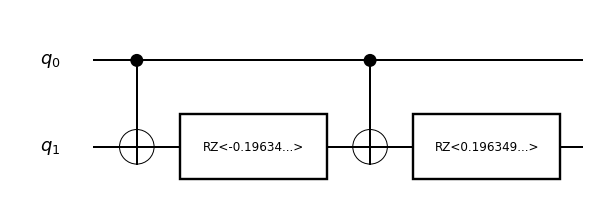

 Controlled(Phase(pi/8)):


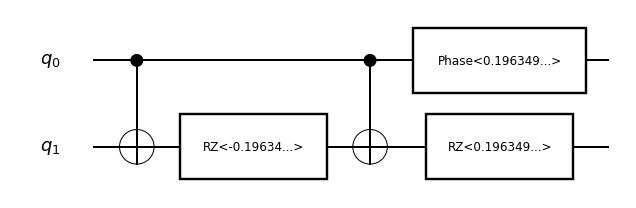

Two qubit non-parametric gates:
 Controlled(CNOT):


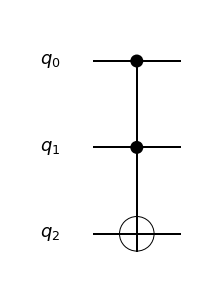

 Controlled(CZ):


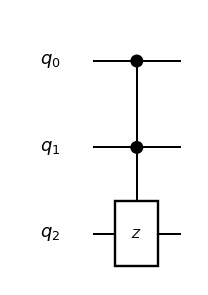

 Controlled(SWAP):


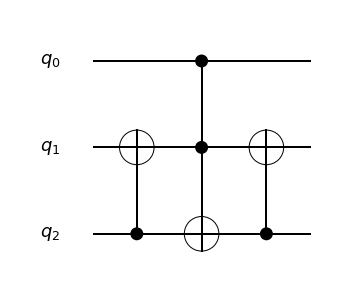

Three qubit non-parametric gates:
 Controlled(Toffoli):


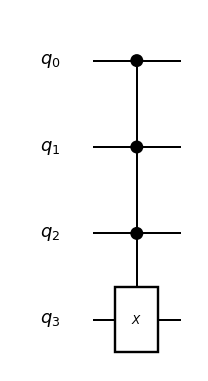

In [ ]:
from math import pi
from IPython.display import display
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.lib import std

print("Single qubit non-parametric gates:")
for op in [
    std.X,
    std.Y,
    std.Z,
    std.H,
    std.SqrtX,
    std.SqrtXdag,
    std.SqrtY,
    std.SqrtYdag,
    std.S,
    std.Sdag,
    std.T,
    std.Tdag,
]:
    ctrl = std.Controlled(op)
    ctrl_sub = resolve_sub(ctrl)
    print(f" Controlled({op.base_id[1]}):")
    display(draw_sub(ctrl_sub))

print("Single qubit parametric rotation gates:")
for op in [
    std.RX,
    std.RY,
    std.RZ,
    std.Phase,
]:
    ctrl = std.Controlled(op(pi/8))
    ctrl_sub = resolve_sub(ctrl)
    print(f" Controlled({op.base_id[1]}(pi/8)):")
    display(draw_sub(ctrl_sub))

print("Two qubit non-parametric gates:")
for op in [
    std.CNOT,
    std.CZ,
    std.SWAP,
]:
    ctrl = std.Controlled(op)
    ctrl_sub = resolve_sub(ctrl)
    print(f" Controlled({op.base_id[1]}):")
    display(draw_sub(ctrl_sub))

print("Three qubit non-parametric gates:")
ctrl = std.Controlled(std.Toffoli)
ctrl_sub = resolve_sub(ctrl)
print(f" Controlled({std.Toffoli.base_id[1]}):")
display(draw_sub(ctrl_sub))

### Resolving MultiControlled

`MultiControlled` operation is resolved using Toffoli gates by default. (An alternative way to resolve it with measurement and conditional operation is also provided, which will be mentioned elsewhere.) In this construction, if the number of control bits is $k$, then $k-1$ auxiliary qubits are added inside the resolved `Sub`.

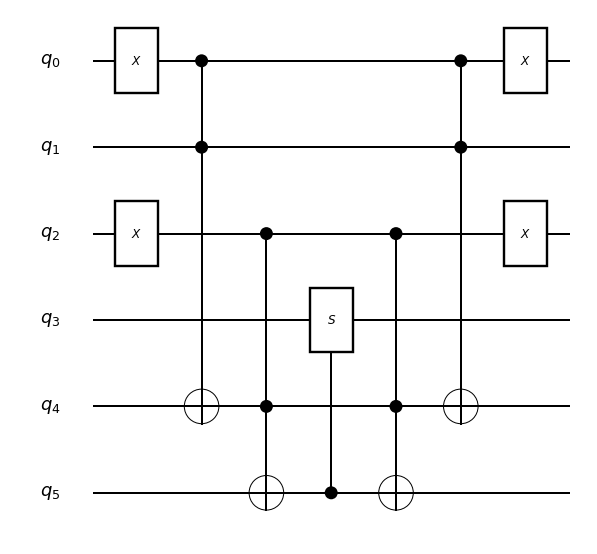

In [ ]:
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.lib import std

mctrlS = std.MultiControlled(std.S, 3, 0b010)
mctrlS_sub = resolve_sub(mctrlS)
draw_sub(mctrlS_sub)

In the above diagram, `q4` and `q5` are auxiliary qubits added inside the resolved `Sub`.

## Compile and analyze a `Sub`

By *compiling* a `Sub`, you can perform various analysis on the compiled circuit (`MachineSub`). Let's prepare a `Sub` to be compiled:

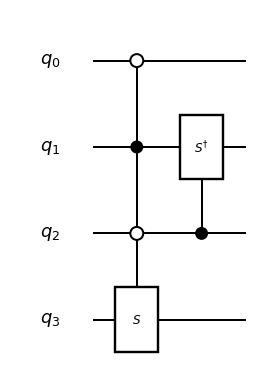

In [ ]:
from quri_parts.qsub.sub import SubBuilder
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.lib import std

# Build a circuit for 4 qubits
b = SubBuilder(4)
q0, q1, q2, q3 = b.qubits
b.add_op(std.MultiControlled(std.S, 3, 0b010), (q0, q1, q2, q3))
b.add_op(std.Controlled(std.Sdag), (q2, q1))
sub = b.build()

draw_sub(sub)

In order to perform compilation you need to determine `primitives`, which specifies which `Op`s you want to treat as primitives (i.e. not replaced by subroutines). When you are not sure which operations to specify as primitives, you can start with a small set and add missing primitives by inspecting an error message:

In [ ]:
from quri_parts.qsub.compile import compile_sub
from quri_parts.qsub.lib import std

primitives = (std.CNOT, std.Toffoli)
try:
    compiled = compile_sub(sub, primitives)
except Exception as e:
    print(e)

Op lib.std.X(qubits=1, registers=0) is not found in calltable.


The error message above tells us that `X` is missing from `primitives`. Repeating the procedure, we can come up with the following primitives for this example.

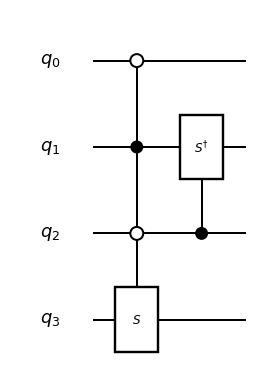

In [ ]:
from quri_parts.qsub.compile import compile_sub
from quri_parts.qsub.visualize import draw_msub
from quri_parts.qsub.lib import std

primitives = (std.X, std.T, std.Tdag, std.CNOT, std.Toffoli)
compiled = compile_sub(sub, primitives)
draw_msub(compiled)

Though the circuit diagram is the same as that before the compilation, the compiled subroutine (`MachineSub`) contains additional information such as definitions of subroutines called internally.

After compilation you can perform several analyses using `Evaluator` and `EvaluatorHooks`.

### Counting gates in the circuit

You can count gates of specific types in the circuit as follows:

In [ ]:
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import GateCountEvaluatorHooks

gate_counter = Evaluator(GateCountEvaluatorHooks((std.T, std.Tdag, std.Toffoli)))
gate_count = gate_counter.run(compiled)
print({k[1]: v for k, v in gate_count.items()})

{'Toffoli': 4, 'Tdag': 3, 'T': 3}


### Counting max number of auxiliary qubits required

Some operations (such as `MultiControlled`) use auxiliary qubits in addition to input/output qubits of the circuit. you can count the maximum number of simultaneously required auxiliary qubits as follows:

In [ ]:
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import AuxQubitCountEvaluatorHooks

aux_counter = Evaluator(AuxQubitCountEvaluatorHooks())
aux_count = aux_counter.run(compiled)
print(f"Max # of aux qubits: {aux_count}")

Max # of aux qubits: 2


### Expand the circuit with primitives

It is possible to expand the circuit with primitives.

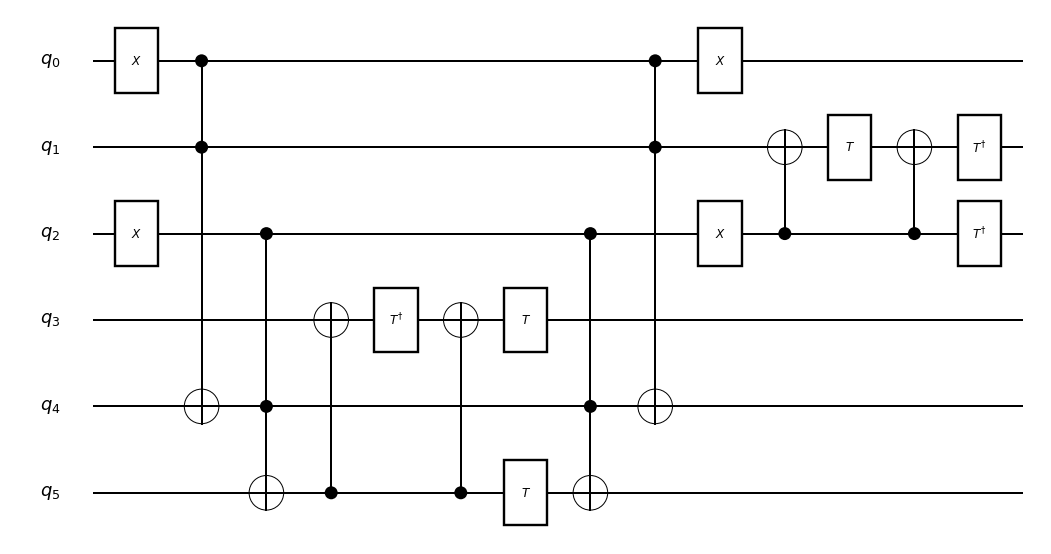

In [ ]:
from quri_parts.qsub.expand import full_expand
from quri_parts.qsub.visualize import draw_msub

expanded = full_expand(compiled)
draw_msub(expanded)

### Convert to QURI Parts circuit

You can convert the compiled subroutine to a QURI Parts circuit as follows:

In [ ]:
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import QURIPartsEvaluatorHooks
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

qp_generator = Evaluator(QURIPartsEvaluatorHooks())
qp_circuit = qp_generator.run(compiled)
draw_circuit(qp_circuit, line_length=120)

   ___                                                                             ___                          
  | X |                                                                           | X |                         
--|0  |-----●-------------------------------------------------------●-------------|11 |-------------------------
  |___|     |                                                       |             |___|                         
            |                                                       |              ___     ___     ___     ___  
            |                                                       |             |CX |   | T |   |CX |   |Tdg| 
------------●-------------------------------------------------------●-------------|13 |---|14 |---|15 |---|17 |-
            |                                                       |             |___|   |___|   |___|   |___| 
   ___      |                                                       |     ___       |           

### Compiling an `Op`

In the above example, we defined a circuit with 4 input/output qubits as a `Sub` and compiled it. It is often more convenient if we don't need to specify the required number of qubits explicitly. This is possible by defining your own (parametric) `Op` and compile it. Defining your own `Op` will be treated in the next section. Here we illustrate compilation of `Op` using pre-defined standard `Op`s.

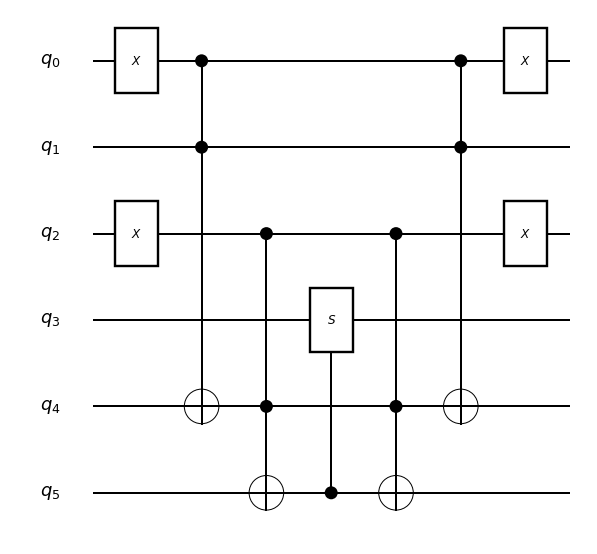

In [ ]:
from quri_parts.qsub.compile import compile
from quri_parts.qsub.visualize import draw_msub
from quri_parts.qsub.lib import std

op = std.MultiControlled(std.S, 3, 0b010)
primitives = (std.X, std.T, std.Tdag, std.CNOT, std.Toffoli)
compiled = compile(op, primitives)
draw_msub(compiled)

Here you don't need to specify the number of qubits of the `Sub` (4) as it is automatically calculated by `MultiControlled`. In this case, the entry `Op`=`MultiControllled<S, 3, 0b010>` is resolved to a `Sub`, so the returned `MachineSub` is the multi-controlled operation expanded by the default rule. On the other hand, it is not fully expanded and it contains non-primitive `Op`s such as `Controlled<S>`.

## Custom `Op` and `Sub`

With knowledge introduced in the preceding sections, you can build a subroutine (`Sub`) using pre-defined operations (`Op`), compile it and analyze the compiled subroutine (`MachineSub`). The next thing you want to do is probably to use your own subroutine inside another subroutine. It is not possible though; a `Sub` can contain `Op`s but not other `Sub`s. In order to call your subroutine from another subroutine, you need to define your own `Op` along with the `Sub` and register a corresponding between them.

### Defining (non-parametric) `Op` and `Sub`

As a simple example, let's define a "majority" operation and its circuit (subroutine).

__default__.Majority(qubits=3, registers=0)


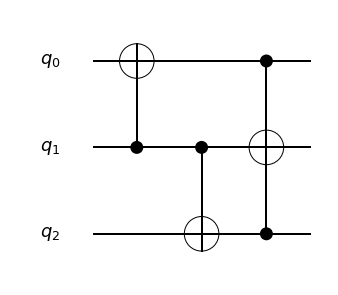

In [ ]:
from quri_parts.qsub.opsub import UnitarySubDef, opsub
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.lib import std

class MajorityDef(UnitarySubDef):
    name = "Majority"
    qubit_count = 3

    def sub(self, builder):  # builder is a SubBuilder instance
        a, b, c = builder.qubits
        builder.add_op(std.CNOT, (b, a))
        builder.add_op(std.CNOT, (b, c))
        builder.add_op(std.Toffoli, (c, a, b))

Majority, _ = opsub(MajorityDef)

print(Majority)
sub = resolve_sub(Majority)
draw_sub(sub)

When defining a unitary `Op` and corresponding `Sub`:

- Define a subclass of `UnitarySubDef`
  - Specify `name` and `qubit_count` attributes
  - Implement `sub()` method that builds the corresponding `Sub`. A `SubBuilder` is passed as an argument. Note that you don't need to call `builder.build()` since it is automatically called later.
- Call `opsub()` with the defined class (not an instance of the class). The function returns two values:
  - The first return value is the defined `Op`.
  - The second return value is the defined `Sub`. You may not need it for the most cases since it is registered to the (default) `SubRepository` and can be later resolved by `resolve_sub()`.

You can use the defined `Op` when building another `Sub`.

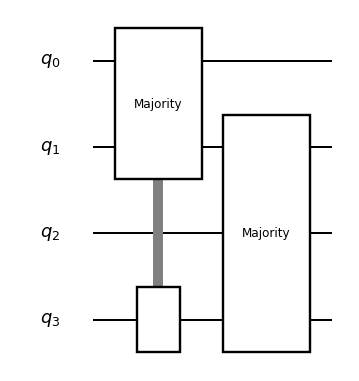

In [ ]:
from quri_parts.qsub.sub import SubBuilder
from quri_parts.qsub.visualize import draw_sub

# Build a circuit for 4 qubits
b = SubBuilder(4)
q0, q1, q2, q3 = b.qubits
b.add_op(Majority, (q0, q1, q3))
b.add_op(Majority, (q1, q2, q3))
sub = b.build()

draw_sub(sub)

### Defining parametric `Op` and `Sub`

You can also define parametric `Op` and `Sub`, which can take some parameters.

- Number of input/output qubits can be determined with the parameter values.
- Construction of the `Sub` can be customized using the parameter values.

We illustrate this by defining "multi-qubit SWAP":

__default__.MultiSWAP<3>(qubits=6, registers=0)


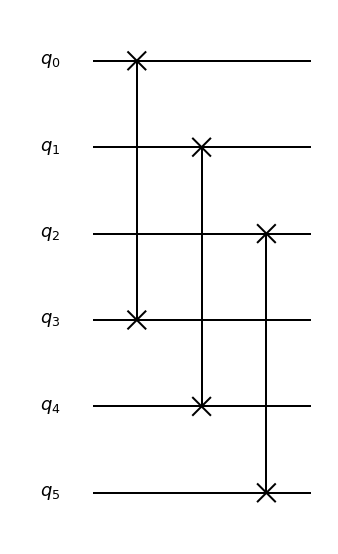

In [ ]:
from quri_parts.qsub.opsub import ParamUnitarySubDef, param_opsub
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.lib import std

class MultiSWAPDef(ParamUnitarySubDef[int]):
    name = "MultiSWAP"

    def qubit_count_fn(self, bits: int):
        return 2 * bits

    def sub(self, builder, bits: int):  # builder is a SubBuilder instance
        x = builder.qubits[:bits]
        y = builder.qubits[bits:]

        for i in range(bits):
            builder.add_op(std.SWAP, (x[i], y[i]))

MultiSWAP, _ = param_opsub(MultiSWAPDef)

print(MultiSWAP(3))
sub = resolve_sub(MultiSWAP(3))
draw_sub(sub)

When defining a parametric unitary `Op` and corresponding `Sub`:

- Define a subclass of `ParamUnitarySubDef`
  - You can specify types of parameters like `ParamUnitarySubDef[int]`. This is optional; it helps static type checking and can also be considered as documentation.
  - Specify `name` attribute.
  - If number of input/output qubits is fixed regardless of parameter values, it can be specified with `qubit_count` attribute.
  - If number of input/output qubits is determined with parameter values, implement `qubit_count_fn()` method that takes the parameter values and returns the number of qubits.
  - Implement `sub()` method that takes the parameter values and builds the corresponding `Sub`. A `SubBuilder` is passed as the first argument and the parameter values are passed as the other arguments. Note that you don't need to call `builder.build()` since it is automatically called later.
- Call `param_opsub()` with the defined class (not an instance of the class). The function returns two values:
  - The first return value is the defined parametric `Op`. It is a function that takes the parameter values and returns an `Op` with the parameters substituted.
  - The second return value is the defined parametric `Sub`. You may not need it for the most cases since it is registered to the (default) `SubRepository` and can be later resolved by `resolve_sub()`.

You can use the defined parametric `Op` when building another `Sub`.

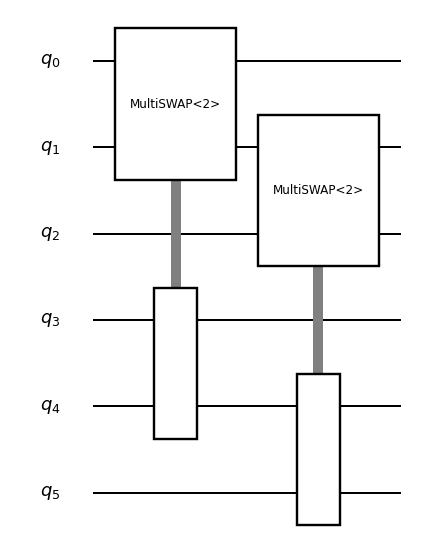

In [ ]:
from quri_parts.qsub.sub import SubBuilder
from quri_parts.qsub.visualize import draw_sub

# Build a circuit for 6 qubits
b = SubBuilder(6)
q0, q1, q2, q3, q4, q5 = b.qubits
b.add_op(MultiSWAP(2), (q0, q1, q3, q4))
b.add_op(MultiSWAP(2), (q1, q2, q4, q5))
sub = b.build()

draw_sub(sub)

### Using with Inverse, Controlled, MultiControlled

User defined `Op`s can be used in the same way as `Op`s in the standard library, in combination with `Op`s in the standard library such as `Inverse`, `Controlled`, or `MultiControlled`. Resolving can be left to the predefined resolver, or if a more efficient resolver is available, it can be registered.

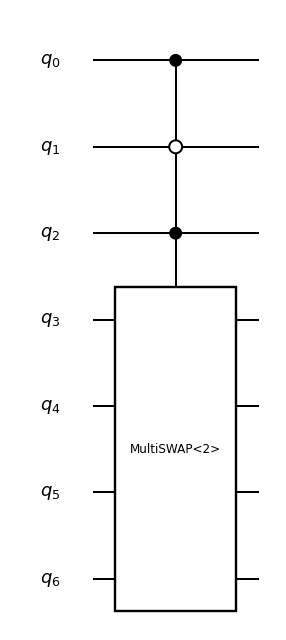

In [ ]:
from quri_parts.qsub.lib import std

MCMS = std.MultiControlled(MultiSWAP(2), 3, 0b101)
b = SubBuilder(7)
b.add_op(MCMS, b.qubits)
sub = b.build()

draw_sub(sub)

## Summary

As introduced above, Qsub makes it relatively easy to construct complex quantum circuits that represent the FTQC algorithm, perform resource estimation, and generate quantum circuits for QURI Parts. Users can define data structures such as `Op` and `Sub` that represent arbitrary quantum operations, which can be combined to form quantum circuits. In addition, commonly used `Op`s and `Sub`s are predefined and available in the standard library. QURI SDK Enterprize also includes a more advanced library for configuring FTQC algorithms.